## **DCGAN with Sign Language Dataset**

**Imports**

In [1]:
import tensorflow as tf
import numpy as np
import zipfile
import urllib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython import display
from tqdm import tqdm
import glob
import imageio.v2 as imageio
import os
from google.colab import drive

**Parameters**

In [2]:
epochs=20
z_dim=64
batch_size=128
buffer_size=1024
resize=(64, 64)
AUTOTUNE=tf.data.AUTOTUNE

**Load and Preprocess the Dataset**

In [3]:
data_url="https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/signs-training.zip"
data_file_name="archive.zip"
urllib.request.urlretrieve(data_url, data_file_name)

training_dir="/content/signs/"
zip_ref = zipfile.ZipFile(data_file_name, "r")
zip_ref.extractall(training_dir)
zip_ref.close()

In [4]:
def process_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_png(img)
  img = tf.image.resize(img, resize, method="bicubic", antialias=True)
  img = tf.cast(img, tf.float32)/127.5 - 1

  return img

In [5]:
dataset_paths = tf.data.Dataset.list_files("/content/signs/signs-training/*.png", shuffle=False)
train_dataset = (dataset_paths
                 .map(process_image)
                 .shuffle(buffer_size, seed=123)
                 .batch(batch_size)
                 .prefetch(AUTOTUNE))

In [6]:
for im in train_dataset.take(1):
  print(im.shape)

(128, 64, 64, 1)


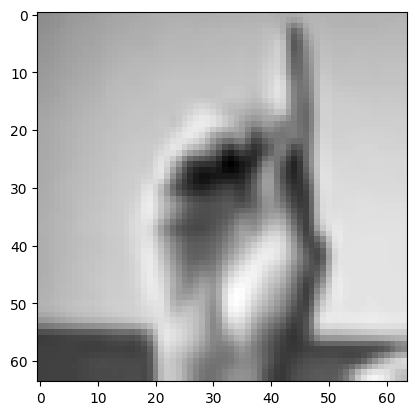

In [7]:
plt.imshow(im[0], cmap="gray");

**Utilities**

In [8]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [9]:
# Images directory
directory_images = "/content/drive/MyDrive/images"
directory_sign_language = os.path.join(directory_images, "sign_language_dcgan")

os.makedirs(directory_sign_language, exist_ok=True)

In [10]:
# Display functions

def make_grid(images, num_examples, nrow):
  images=tf.unstack(images[:num_examples], axis=0)
  images=tf.concat(images, axis=1)
  images=tf.split(images, nrow, axis=1)
  images=tf.concat(images, axis=0)

  return images

def show_and_save_images(real_images, fake_images, epoch, num_examples=25, nrow=5):

  real_images = make_grid(real_images, num_examples, nrow)
  fake_images = make_grid(fake_images, num_examples, nrow)
  real_images = tf.cast((real_images+1) * 127.5, tf.uint8) # Denormalization
  fake_images = tf.cast((fake_images+1) * 127.5, tf.uint8)

  fig, ax = plt.subplots(1, 2, figsize=(nrow*2, nrow*2))
  ax[0].imshow(fake_images, cmap="gray")
  ax[0].axis("off")
  ax[0].set_title("Generated Images")

  ax[1].imshow(real_images, cmap="gray")
  ax[1].axis("off")
  ax[1].set_title("Real Images")

  plt.show()

  # Save fake images
  plt.imshow(fake_images, cmap="gray")
  plt.axis("off")
  plt.savefig(os.path.join(directory_sign_language, f"image{epoch:02d}.png"), transparent=True)
  plt.close()

**Build the Model**

In [11]:
tf.keras.backend.clear_session()

In [12]:
def model_generator(z_dim=z_dim):
  initializer = tf.keras.initializers.RandomNormal(0., 0.02, seed=123)

  input=tf.keras.Input(shape=(1, 1, z_dim))
  x=tf.keras.layers.Conv2DTranspose(512, (4,4), strides=1, padding="valid", kernel_initializer=initializer, use_bias=False)(input)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.Dropout(0.5)(x)
  x=tf.keras.layers.ReLU()(x)

  x=tf.keras.layers.Conv2DTranspose(256, (4,4), strides=2, padding="same", kernel_initializer=initializer, use_bias=False)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.Dropout(0.5)(x)
  x=tf.keras.layers.ReLU()(x)

  x=tf.keras.layers.Conv2DTranspose(128, (4,4), strides=2, padding="same", kernel_initializer=initializer, use_bias=False)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.ReLU()(x)

  x=tf.keras.layers.Conv2DTranspose(64, (4,4), strides=2, padding="same", kernel_initializer=initializer, use_bias=False)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.ReLU()(x)

  x=tf.keras.layers.Conv2DTranspose(1, (4,4), strides=2, padding="same", kernel_initializer=initializer, activation="tanh")(x)

  model=tf.keras.Model(inputs=input, outputs=x, name="generator")

  return model

In [13]:
generator = model_generator()
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1, 64)]        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         524288    
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 4, 4, 512)         2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 4, 4, 512)         0         
                                                                 
 re_lu (ReLU)                (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 256)         20

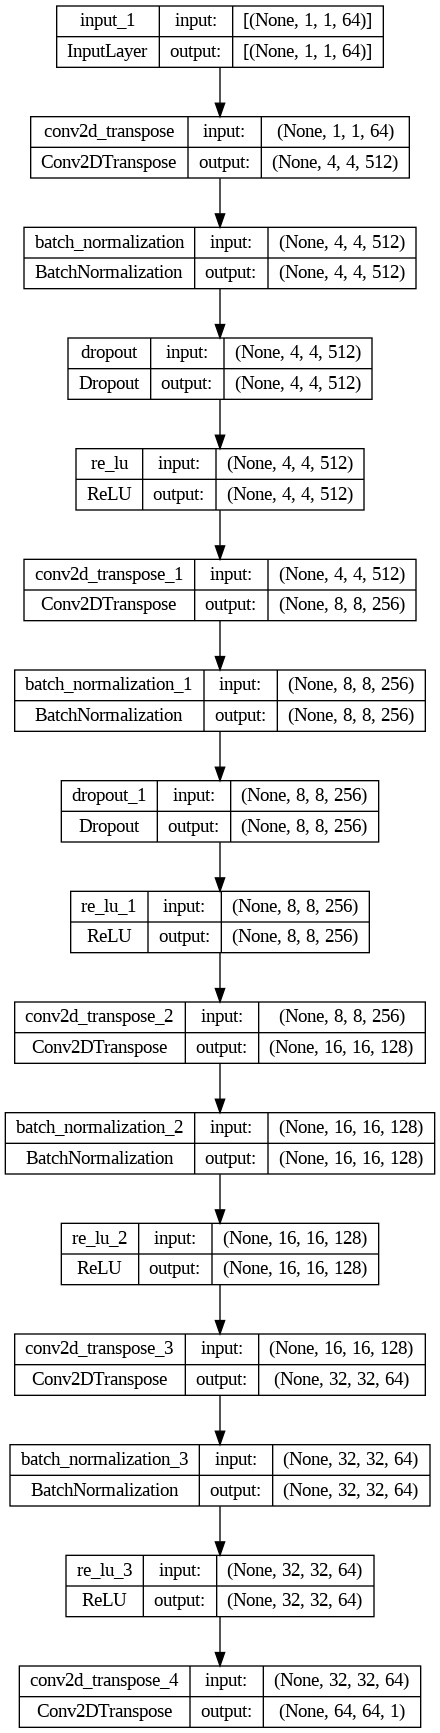

In [ ]:
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=True)

In [14]:
def model_discriminator():
  initializer = tf.keras.initializers.RandomNormal(0., 0.02, seed=123)

  input=tf.keras.Input(shape=(64, 64, 1))
  x=tf.keras.layers.Conv2D(64, (4,4), strides=2, padding="same", kernel_initializer=initializer, use_bias=False)(input)
  x=tf.keras.layers.LeakyReLU(0.2)(x)

  x=tf.keras.layers.Conv2D(128, (4,4), strides=2, padding="same", kernel_initializer=initializer, use_bias=False)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.LeakyReLU(0.2)(x)

  x=tf.keras.layers.Conv2D(256, (4,4), strides=2, padding="same", kernel_initializer=initializer, use_bias=False)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.LeakyReLU(0.2)(x)

  x=tf.keras.layers.Conv2D(512, (4,4), strides=2, padding="same", kernel_initializer=initializer, use_bias=False)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.LeakyReLU(0.2)(x)

  x=tf.keras.layers.Conv2D(1, (4,4), strides=1, kernel_initializer=initializer)(x)
  x=tf.keras.layers.Flatten()(x)

  model=tf.keras.Model(inputs=input, outputs=x, name="discriminator")

  return model

In [15]:
discriminator = model_discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_4 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                     

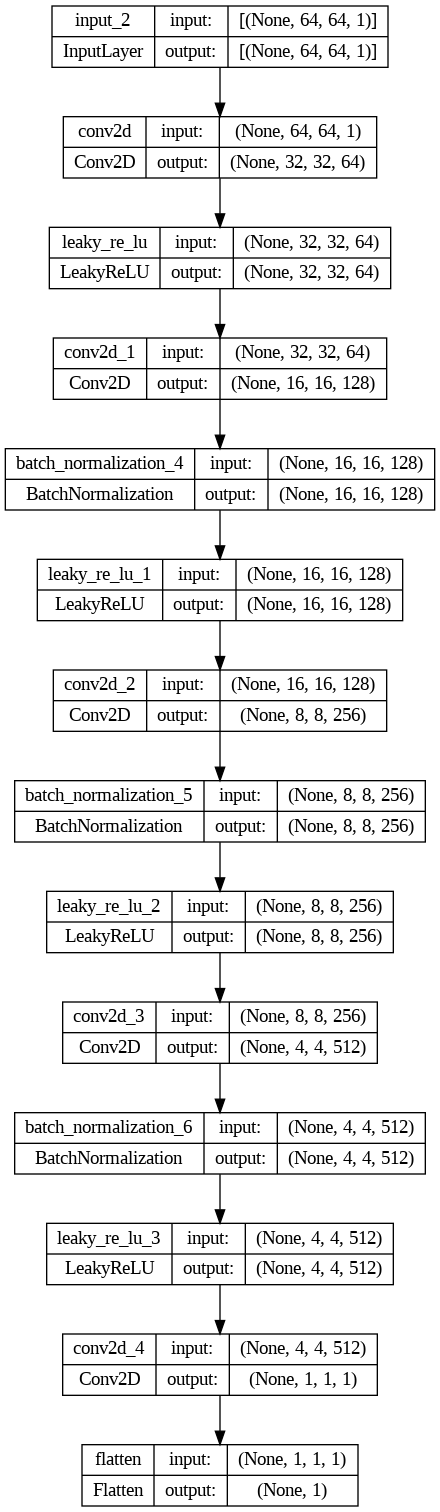

In [ ]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_names=True)

**Train the Model**

In [16]:
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
loss_model = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
@tf.function
def train_step(real_images):
  cur_batch_size = len(real_images)
  noise = tf.random.normal(shape=(cur_batch_size, 1, 1, z_dim))

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    fake_images = generator(noise, training=True)

    real_out = discriminator(real_images, training=True)
    fake_out = discriminator(fake_images, training=True)

    # Generator Loss
    gen_loss = loss_model(tf.ones_like(fake_out), fake_out)

    # Discriminator Loss
    real_loss = loss_model(tf.ones_like(real_out), real_out)
    fake_loss = loss_model(tf.zeros_like(fake_out), fake_out)
    disc_loss = (fake_loss+real_loss) / 2

  gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
  disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

  return gen_loss, disc_loss

Generate random images to create the GIF

In [18]:
tf.random.set_seed(123) #for the reproducibility of noise tensor
num_examples = 25
nrow = 5

noise = tf.random.normal((num_examples, 1, 1, z_dim))
fake_images = generator(noise, training=False)

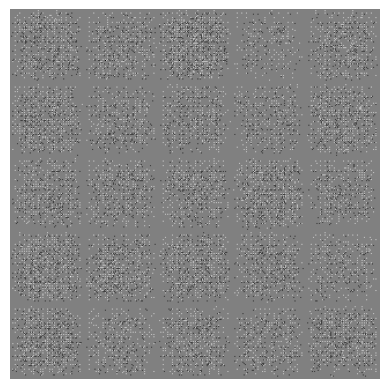

In [19]:
# Epoch 0 image
fake_images = make_grid(fake_images, num_examples, nrow)
fake_images = tf.cast((fake_images+1) * 127.5, tf.uint8) # Denormalization
plt.imshow(fake_images, cmap="gray")
plt.axis("off")
plt.savefig(os.path.join(directory_sign_language, f"image{0:02d}.png"), transparent=True);

In [20]:
# Training function
def train_gan(epochs=epochs, num_examples=num_examples, nrow=nrow):
  history={"gen_loss":[], "disc_loss":[]}

  for epoch in range(epochs):
    gen_loss_list, disc_loss_list = [], []

    with tqdm(train_dataset) as pbar:
      pbar.set_description(f"[Epoch: {epoch+1}/{epochs}]")
      for real_images in pbar:
        gen_loss, disc_loss = train_step(real_images)

        gen_loss_list.append(gen_loss.numpy())
        disc_loss_list.append(disc_loss.numpy())

        pbar.set_postfix({"gen_loss": gen_loss.numpy(), "disc_loss": disc_loss.numpy()})

    gen_loss_mean = np.mean(gen_loss_list)
    disc_loss_mean = np.mean(disc_loss_list)
    history["gen_loss"].append(gen_loss_mean)
    history["disc_loss"].append(disc_loss_mean)

    display.clear_output(wait=False)
    print(f"Epoch {epoch+1}, GeneratorLoss: {gen_loss_mean}, DiscriminatorLoss: {disc_loss_mean}")
    # Examples for training and GIF
    fake_images = generator(noise, training=False)
    show_and_save_images(real_images, fake_images, epoch+1, num_examples, nrow)

  return history

Epoch 20, GeneratorLoss: 5.128326892852783, DiscriminatorLoss: 0.0201000664383173


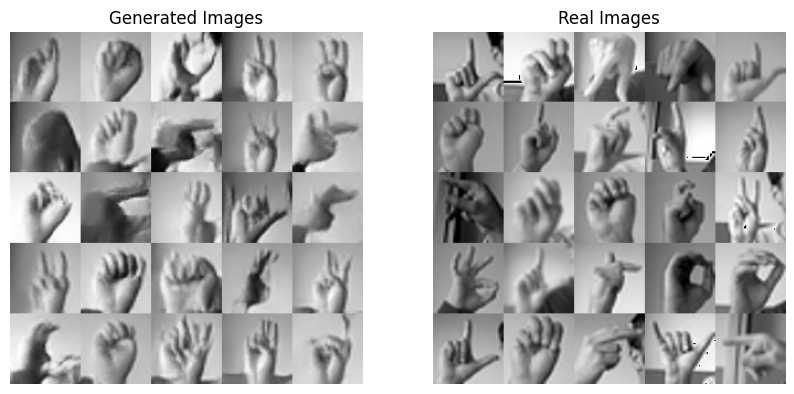

In [21]:
tf.random.set_seed(123)

history = train_gan()

In [ ]:
# Function to plot the losses
def plot_metrics(history, renderer=None, epochs=epochs):
  gen_losses=history["gen_loss"]
  disc_losses=history["disc_loss"]
  list_epochs=np.arange(1, epochs+1)

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=gen_losses, name="Generator Loss", line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=disc_losses, name="Discriminator Loss", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text="Loss")
  fig.update_layout(title=f"<b>Evolution of Loss across Epochs</b>",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

In [23]:
# Interactive graphic
plot_metrics(history)

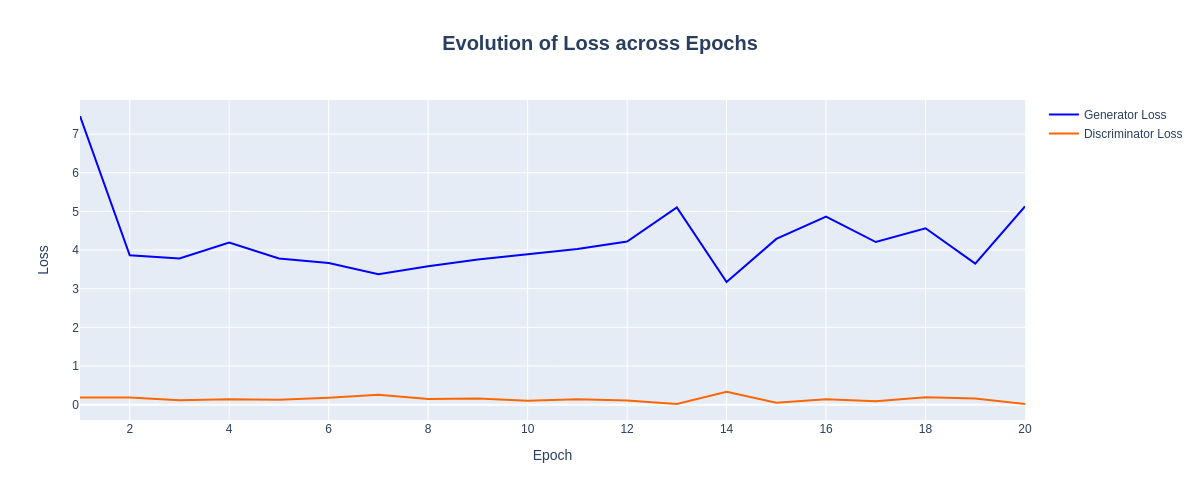

In [10]:
# Image for GitHub
plot_metrics(history, renderer="png")

In [28]:
# Save the generator

generator.save("/content/drive/MyDrive/models/generator_sign_language_dcgan.keras")

**Create a GIF from the generated images**

In [29]:
!pip install tensorflow_docs -q

import tensorflow_docs.vis.embed as embed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 936.1 kB/s eta 0:00:00


In [30]:
# Function to create gifs

def create_gif(gif_file, images_file, fps=1):
  with imageio.get_writer(gif_file, mode="I", loop=0, fps=fps) as writer:
    filenames = sorted(glob.glob(f"{images_file}/*.png"))
    for filename in filenames:
      image = imageio.imread(filename)
      writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


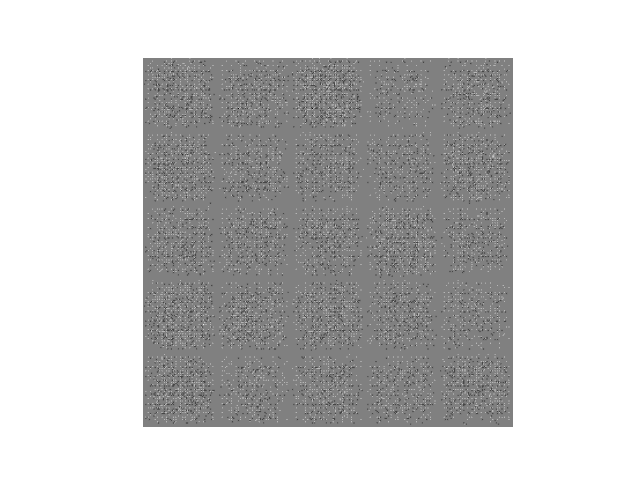

In [32]:
gif_file = os.path.join(directory_sign_language, "sign_language_dcgan.gif")
create_gif(gif_file, directory_sign_language, fps=2)
embed.embed_file(gif_file)

**Generated Examples**

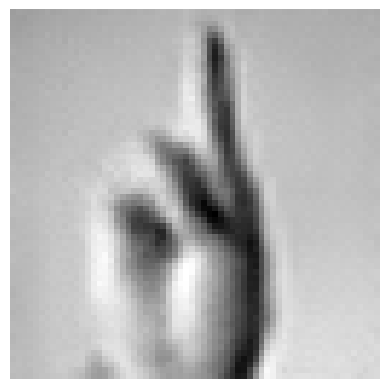

In [36]:
# Generated Example
noise = tf.random.normal(shape=(1, 1, 1, z_dim))
generated_example = generator(noise).numpy().squeeze()
plt.imshow(generated_example, cmap="gray")
plt.axis("off");

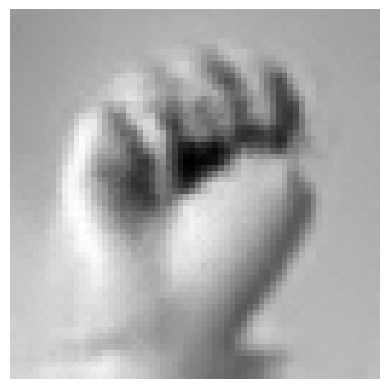

In [34]:
# Generated Example
noise = tf.random.normal(shape=(1, 1, 1, z_dim))
generated_example = generator(noise).numpy().squeeze()
plt.imshow(generated_example, cmap="gray")
plt.axis("off");